<a href="https://colab.research.google.com/github/osanseviero/hackerllama/blob/main/nbs/blog/posts/sentence_embeddings/index.ipynb" rel="nofollow"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"></a>

这个系列旨在揭示嵌入（embeddings）的奥秘，并向您展示如何在项目中使用它们。本系列的第一篇博客将教您如何使用和扩展开源嵌入模型。我们将探讨选择现有模型的标准、当前的评估方法以及生态系统的现状。我们还将深入研究三个令人兴奋的技术实践案例：


* 寻找最相似的Quora或StackOverflow问题（注：Quora为美国一个著名的问答网站，Stack Overflow是一个美国的程序员问答网站）
* 在给定的大型数据集中，找到最相似的项
* 在用户浏览器中直接运行搜索嵌入模型（无需服务器）

您可以在这里阅读内容，或通过点击页面顶部的 Google Colab 徽章在 Google Colab 中执行它。让我们深入了解嵌入！

## 摘要

也许你一直在阅读关于“嵌入这个”和“嵌入那个”的内容，但你可能仍然不完全了解嵌入究竟是什么。你并不孤单！即使你对嵌入只有一个模糊的概念，你仍可通过一个黑匣子 API（注：因为训练的模型，我们并不知道模型工作时内部信息传递方式是如何的，因此称作黑盒）去使用模型，而你并不知道模型内部发生了什么。这是一个问题，因为当前开源的嵌入模型的性能非常强大-它们容易不但容易部署，而且体积小（因此托管成本较低），并且胜过许多闭源模型。

嵌入将信息表现为一组数字（名为向量）（可以将其视为列表！）。例如，我们可以获得单词、句子、文档、图像、音频文件等的值。给定句子“今天是个晴天”，我们可以获得其向量值，它将是一个特定大小的向量，例如384个数字（这样的向量可能看起来像 [0.32, 0.42, 0.15, …, 0.72]）。有趣的是，嵌入捕捉到了信息的语义含义。例如，句子“今天是个晴天”和句子“今天天气不错”非常相似。即使单词不同，含义相似，嵌入的向量值也会反映出这一点。

:::callout

如果你不确定诸如“向量”、“语义相似性”、“向量大小”或“预训练”等术语的含义，不用担心！我们将在接下来的部分对它们进行逐一解释。我们首先要先专注于浅层次的理解。

:::

因此，这个向量捕捉到了信息的语义含义，使得它们更容易相互比较。例如，我们可以使用向量来在Quora或StackOverflow中找到相似的问题，搜索代码，找到相似的图像等。让我们深入了解一些代码！

我们将使用Sentence Transformers，这是一个开源的第三方python库，它使得预训练嵌入模型的使用变得非常简单。具体来说，Sentence Transformers允许我们快速将句子由自然语言转换为向量。让我们运行一个例子，然后讨论它在幕后是如何工作的。

让我们开始安装这个库：

In [ ]:
%%capture
!pip install sentence_transformers

第二步是加载一个已存在的模型。我们将开始使用 [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)。虽然它不是最好的开源向量模型，但它相当受用户欢迎且参数量非常小（2300万参数），这意味着我们可以非常快速地开始使用它。

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

既然我们已经加载了一个模型，让我们使用它来对一些句子进行编码。我们可以使用`encode`方法来获得一个句子列表的向量值。让我们试一试吧！

In [ ]:
from sentence_transformers import util

sentences = ["The weather today is beautiful", "It's raining!", "Dogs are awesome"]
embeddings = model.encode(sentences)
embeddings.shape

(3, 384)

all-MiniLM-L6-v2创建了包含384个向量值的嵌入。我们获得了三个向量，每个向量对应一句话。将`embeddings`视为嵌入的“数据库”。给定一个新的句子，我们如何找到最相似的句子呢？我们可以使用`util.pytorch_cos_sim`方法计算新句子的向量值与数据库中所有向量值之间的余弦相似度（我们很快会详细讨论它）。余弦相似度是一个介于0和1之间的数字，表示两个向量有多相似。值为1意味着向量是相同的，而值为0意味着向量是完全不同的。让我们试一试吧！

In [ ]:
first_embedding = model.encode("Today is a sunny day")
for embedding, sentence in zip(embeddings, sentences):
    similarity = util.pytorch_cos_sim(first_embedding, embedding)
    print(similarity, sentence)

tensor([[0.7344]]) The weather today is beautiful
tensor([[0.4180]]) It's raining!
tensor([[0.1060]]) Dogs are awesome


我们对此可以得出什么解释呢？尽管“today is a sunny day”和“the weather today is beautiful”没有相同的词，但嵌入可以捕捉到一些语义含义，因此余弦相似度相对较高。另一方面，“Dogs are awesome”，虽然正确，但与天气或今天无关；因此，余弦相似度非常低。

为了深入探讨相似嵌入的这个概念，让我们看看它们如何在产品中使用。想象一下，美国社会保障局希望允许用户在输入框中提出与医疗保险相关的问题。这个话题非常敏感，我们可能不希望模型产生与此无关的幻觉！相反，我们可以利用一个问题数据库（在这种情况下，存在一个现有的医疗保险常见问题解答）。这个过程与上面类似：

1. 我们有一个问题和答案的语料库（集合）。
2. 我们计算所有问题的向量值。
3. 给定一个新问题，我们计算它的向量值。
4. 计算新问题向量与数据库中所有向量之间的余弦相似度。
5. 我们返回与最相似嵌入相关联的最相似的问题。

步骤1和2可以在离线状态下完成（即，我们仅计算一次嵌入并存储它们）。其余步骤可以在搜索时进行（每当用户提出一个问题时）。让我们看看这在代码中是什么样子的。

[![Representation of embeddings in two dimensions](https://github.com/osanseviero/hackerllama/blob/main/nbs/blog/posts/sentence_embeddings/embedding.png?raw=1)](https://huggingface.co/spaces/sentence-transformers/embeddings-semantic-search)

让我们先创建我们的常见问题的映射

In [ ]:
# Data from https://faq.ssa.gov/en-US/topic/?id=CAT-01092

faq = {
    "How do I get a replacement Medicare card?": "If your Medicare card was lost, stolen, or destroyed, you can request a replacement online at Medicare.gov.",
    "How do I sign up for Medicare?": "If you already get Social Security benefits, you do not need to sign up for Medicare. We will automatically enroll you in Original Medicare (Part A and Part B) when you become eligible. We will mail you the information a few months before you become eligible.",
    "What are Medicare late enrollment penalties?": "In most cases, if you don’t sign up for Medicare when you’re first eligible, you may have to pay a higher monthly premium. Find more information at https://faq.ssa.gov/en-us/Topic/article/KA-02995",
    "Will my Medicare premiums be higher because of my higher income?": "Some people with higher income may pay a larger percentage of their monthly Medicare Part B and prescription drug costs based on their income. We call the additional amount the income-related monthly adjustment amount.",
    "What is Medicare and who can get it?": "Medicare is a health insurance program for people age 65 or older. Some younger people are eligible for Medicare including people with disabilities, permanent kidney failure and amyotrophic lateral sclerosis (Lou Gehrig’s disease or ALS). Medicare helps with the cost of health care, but it does not cover all medical expenses or the cost of most long-term care.",
}

然后，我们使用`encode`方法来获取所有问题的嵌入。

In [ ]:
corpus_embeddings = model.encode(list(faq.keys()))
print(corpus_embeddings.shape)

(5, 384)


一旦用户提出一个问题，我们就会获取它的嵌入。通常我们将这个嵌入称为查询嵌入。

In [ ]:
user_question = "Do I need to pay more after a raise?"
query_embedding = model.encode(user_question)
query_embedding.shape

(384,)

现在我们可以计算语料库嵌入和查询嵌入之间的相似度。我们可以使用循环并像之前一样使用`util.pytorch.cos_sim`，但是Sentence Transformers提供了一个更友好的方法叫做`semantic_search`，它为我们完成了所有的工作。它返回前k个最相似的嵌入及它们的相似度分数。让我们试试吧！

In [ ]:
similarities = util.semantic_search(query_embedding, corpus_embeddings, top_k=3)
similarities

[[{'corpus_id': 3, 'score': 0.35796287655830383},
  {'corpus_id': 2, 'score': 0.2787758708000183},
  {'corpus_id': 1, 'score': 0.15840476751327515}]]

现在让我们看看这对应哪些问题和答案：

In [ ]:
for i, result in enumerate(similarities[0]):
    corpus_id = result["corpus_id"]
    score = result["score"]
    print(f"Top {i+1} question (p={score}): {list(faq.keys())[corpus_id]}")
    print(f"Answer: {list(faq.values())[corpus_id]}")

Top 1 question (p=0.35796287655830383): Will my Medicare premiums be higher because of my higher income?
Answer: Some people with higher income may pay a larger percentage of their monthly Medicare Part B and prescription drug costs based on their income. We call the additional amount the income-related monthly adjustment amount.
Top 2 question (p=0.2787758708000183): What are Medicare late enrollment penalties?
Answer: In most cases, if you don’t sign up for Medicare when you’re first eligible, you may have to pay a higher monthly premium. Find more information at https://faq.ssa.gov/en-us/Topic/article/KA-02995
Top 3 question (p=0.15840476751327515): How do I sign up for Medicare?
Answer: If you already get Social Security benefits, you do not need to sign up for Medicare. We will automatically enroll you in Original Medicare (Part A and Part B) when you become eligible. We will mail you the information a few months before you become eligible.


太好了，所以针对问题"Do I need to pay more after a raise?"，我们知道最相似的问题是"Will my Medicare premiums be higher because of my higher income?"，因此我们可以返回提供的答案。在实践中，你可能会有数千到数百万个嵌入，但这是一个简单而又强大的例子，展示了如何使用嵌入来找到相似的问题。

既然我们更好地理解了嵌入是什么以及它们如何被使用，让我们深入研究一下它们吧！

## 从单词嵌入到句子嵌入

### Word2Vec和GloVe

现在是时候退后一步，了解更多关于嵌入以及它们为何被需要的知识了。像BERT这样的神经网络不能直接处理单词；它们需要数字。而提供单词的方法是将它们表示为向量，也称为单词嵌入。

在传统的设置中，您定义了一个词汇表（指定了允许的单词），然后该词汇表中的每个单词都有一个分配的嵌入。不在词汇表中的单词被映射到一个特殊的标记，通常称为<UNK>（表示训练期间未找到的标准占位符单词）。例如，假设我们有一个包含三个单词的词汇表，并且我们为每个单词分配了一个大小为五的向量。我们可能有以下嵌入：

| Word | Embedding |
| ---- | --------- |
| king    | [0.15, 0.2, 0.2, 0.3, 0.5] |
| queen   | [0.12, 0.1, 0.19, 0.3, 0.47] |
| potato    | [0.13, 0.4, 0.1, 0.15, 0.01] |
| `<UNK>`    | [0.01, 0.02, 0.01, 0.4, 0.11] |

我上面写的嵌入是我随机写的数字。实际上，**这些嵌入是通过学习得到的**。这是诸如[Word2Vec](https://en.wikipedia.org/wiki/Word2vec)和[GloVe](https://nlp.stanford.edu/pubs/glove.pdf)等方法的主要思想。它们以这样一种方式学习语料库中单词的嵌入，即出现在相似上下文中的单词具有相似的嵌入。例如，"king"和"queen"的嵌入是相似的，因为它们出现在相似的上下文中。

[![Word embeddings](https://github.com/osanseviero/hackerllama/blob/main/nbs/blog/posts/sentence_embeddings/embedding.png?raw=1)](https://huggingface.co/spaces/sentence-transformers/embeddings-semantic-search)

一些开源库，如Gensim和fastText，允许您快速获取预训练的Word2Vec和GloVe嵌入。在NLP的“黄金时代”（2013年），人们使用这些模型来计算单词嵌入，这对于其他模型的输入非常有帮助。例如，您可以计算句子中每个单词的单词嵌入，然后将其作为输入传递给scikit-learn分类器，以对句子的情感进行分类。

GloVe和Word2Vec具有固定的表示形式。一旦它们被训练，每个单词都被分配一个固定的向量表示，不考虑它们的上下文（因此，“river bank”中的“bank”和“savings bank”中的“bank”将具有相同的嵌入）。**Word2Vec和GloVe在处理具有多个含义的单词时会遇到困难。**

![The good ol' days of NLP](https://github.com/osanseviero/hackerllama/blob/main/nbs/blog/posts/sentence_embeddings/word2vec_meme.jpeg?raw=1)


:::注意

了解word2vec和GloVe的细节对于理解博客文章的其余部分和句子嵌入是不必要的，所以我会跳过它们。如果你感兴趣的话，我建议阅读这门出色的交互式NLP课程中的这一章节。

长话短说

* Word2Vec 是通过传递一个非常大的语料库并训练一个浅层神经网络来预测周围的单词来进行训练的。后来的替代方法则是根据周围的单词来预测中心单词。
* GloVe 是通过查看单词的共现矩阵（单词在一定距离内一起出现的频率）进行训练的，然后使用该矩阵来获取嵌入。

Word2Vec 和 GloVe 的训练目标确保出现在相似上下文中的单词具有相似的嵌入。

:::

### 使用Transformers的词嵌入

最近，随着Transformer的出现，我们有了新的计算嵌入的方式。嵌入也是通过学习获得的，但与训练一个嵌入模型，然后再为特定任务训练另一个模型不同，Transformer在其任务的上下文中学习有用的嵌入。例如，BERT，一个流行的Transformer模型，在掩码语言建模（预测哪个单词填在空白处）和下一个句子预测（句子B是否跟在句子A后面）的上下文中学习单词嵌入。

Transformer在许多NLP任务中是最先进的，并且能够捕捉word2vec和GloVe无法捕捉到的上下文信息，这要归功于一种称为注意力的机制。注意力允许模型权衡其他单词的重要性并捕捉上下文信息。例如，在句子“I went to the bank to deposit money”中，单词“bank”是含糊的。它是河岸还是储蓄银行？模型可以使用单词“deposit”来理解它是一个储蓄银行。这些是**上下文化的嵌入** - 它们的单词嵌入可以根据周围的单词而不同。

好的...我们谈了很多关于词嵌入的内容；是时候运行一些代码了。让我们使用一个预训练的Transformer模型，[bert-base-uncased](https://huggingface.co/bert-base-uncased)，并获取一些单词嵌入。我们将使用`transformers`库来实现这一点。让我们首先加载模型及其分词器。

In [ ]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

到目前为止，我们还没有讨论过分词(tokenization)。直到现在，我们假设我们将数据分割成单词。当使用transformers时，我们将文本分割为标记(tokens)。例如，单词“banking”可以被分成两个标记，“bank”和“ing”。分词器负责将数据分割成标记，它分割数据的方式是模型特定的，并且是一个确定性学习过程，这意味着相同的单词将始终被分割成相同的标记。让我们看看代码中是什么样子的：

In [ ]:
text = "The king and the queen are happy."
tokenizer.tokenize(text, add_special_tokens=True)

['[CLS]', 'the', 'king', 'and', 'the', 'queen', 'are', 'happy', '.', '[SEP]']

好的，在这个例子中，每个单词都是一个标记！（但这并不总是如此，我们很快就会看到）。但我们还看到了两件可能意外的事情：`[CLS]` 和 `[SEP]`。这些是添加到句子开头和结尾的特殊标记。这些是因为BERT是以这种格式进行训练的。BERT的训练目标之一是下一个句子预测，这意味着它被训练来预测两个句子是否是连续的。`[CLS]` 标记表示整个句子，而 `[SEP]` 标记分隔句子。当我们谈论句子嵌入时，这将会很有趣。

 现在让我们获取每个标记的嵌入。

In [ ]:
encoded_input = tokenizer(text, return_tensors="pt")
output = model(**encoded_input)
output["last_hidden_state"].shape

torch.Size([1, 10, 768])

太好了！BERT为我们提供了每个标记的768个值的嵌入。这些标记都包含语义信息 - **它们捕捉了单词在句子上下文中的含义**。让我们看看在这个上下文中对应于单词"king"的嵌入是否与"queen"的嵌入相似。

In [ ]:
king_embedding = output["last_hidden_state"][0][2]  # 2 is the position of king
queen_embedding = output["last_hidden_state"][0][5]  # 5 is the position of queen
print(f"Shape of embedding {king_embedding.shape}")
print(
    f"Similarity between king and queen embedding {util.pytorch_cos_sim(king_embedding, queen_embedding)[0][0]}"
)

Shape of embedding torch.Size([768])
Similarity between king and queen embedding 0.7920711040496826


好的，在这个上下文中它们看起来是相当相似的！现在让我们看一下单词"happy"。

In [ ]:
happy_embedding = output.last_hidden_state[0][7]  # happy
util.pytorch_cos_sim(king_embedding, happy_embedding)

tensor([[0.5239]], grad_fn=<MmBackward0>)

这是合理的；皇后的嵌入与国王的更相似，而不是快乐的嵌入。

现在让我们看看同一个单词在不同的上下文中可能具有不同的值：

In [ ]:
text = "The angry and unhappy king"
encoded_input = tokenizer(text, return_tensors="pt")
output = model(**encoded_input)
output["last_hidden_state"].shape

torch.Size([1, 7, 768])

In [ ]:
tokenizer.tokenize(text, add_special_tokens=True)

['[CLS]', 'the', 'angry', 'and', 'unhappy', 'king', '[SEP]']

In [ ]:
king_embedding_2 = output["last_hidden_state"][0][5]
util.pytorch_cos_sim(king_embedding, king_embedding_2)

tensor([[0.5740]], grad_fn=<MmBackward0>)

哇！尽管两个嵌入似乎对应于"king"的嵌入，但它们在向量空间中相差很大。发生了什么？请记住，这些是上下文化嵌入。第一个句子的上下文非常积极，而第二个句子的上下文则相当消极。因此，这些嵌入是不同的。

之前，我们讨论了分词器如何将一个单词分成多个标记的情况。一个合理的问题是在这种情况下我们如何获得单词嵌入。让我们来看一个例子，使用长单词“tokenization”。

In [ ]:
tokenizer.tokenize("tokenization")

['token', '##ization']

单词"tokenization"被分成了两个标记，但我们关心的是"tokenization"的嵌入！我们可以采取一种汇聚策略，其中我们获取每个标记的嵌入，然后对它们进行平均以获得单词嵌入。让我们试试看！

和之前一样，我们首先对文本进行分词，然后将标记ID传递给模型。

In [ ]:
text = "this is about tokenization"

encoded_input = tokenizer(text, return_tensors="pt")
output = model(**encoded_input)

让我们看一下对句子进行的分词处理：

In [ ]:
tokenizer.tokenize(text, add_special_tokens=True)

['[CLS]', 'this', 'is', 'about', 'token', '##ization', '[SEP]']

所以我们想要通过对标记4和5的嵌入进行平均来汇集它们的嵌入。让我们首先获取这些标记的嵌入。

In [ ]:
word_token_indices = [4, 5]
word_embeddings = output["last_hidden_state"][0, word_token_indices]
word_embeddings.shape

torch.Size([2, 768])

现在让我们使用`torch.mean`对它们进行平均。

In [ ]:
import torch

torch.mean(word_embeddings, dim=0).shape

torch.Size([768])

让我们将所有这些内容封装到一个函数中，这样我们以后就可以轻松使用它。

In [ ]:
def get_word_embedding(text, word):
    # Encode the text and do a forward pass through the model to get the hidden states
    encoded_input = tokenizer(text, return_tensors="pt")
    with torch.no_grad():  # We don't need gradients for embedding extraction
        output = model(**encoded_input)

    # Find the indices for the word
    word_ids = tokenizer.encode(
        word, add_special_tokens=False
    )  # No special tokens anymore
    word_token_indices = [
        i
        for i, token_id in enumerate(encoded_input["input_ids"][0])
        if token_id in word_ids
    ]

    # Pool the embeddings for the word
    word_embeddings = output["last_hidden_state"][0, word_token_indices]
    return torch.mean(word_embeddings, dim=0)

**例子1.** 在两者都生气的情况下，"king"和"queen"嵌入之间的相似度。

In [ ]:
util.pytorch_cos_sim(
    get_word_embedding("The king is angry", "king"),
    get_word_embedding("The queen is angry", "queen"),
)

tensor([[0.8564]])

**例子2.** 在king快乐而queen生气的情况下，"king"和"queen"嵌入之间的相似度。请注意，它们比之前的例子中相似度较低。

In [ ]:
util.pytorch_cos_sim(
    get_word_embedding("The king is happy", "king"),
    get_word_embedding("The queen is angry", "queen"),
)

tensor([[0.8273]])

**例子3**. 在两个非常不同的上下文中，"king"嵌入之间的相似度。即使它们是相同的单词，单词的不同上下文使得嵌入非常不同。

In [ ]:
# This is same as before
util.pytorch_cos_sim(
    get_word_embedding("The king and the queen are happy.", "king"),
    get_word_embedding("The angry and unhappy king", "king"),
)

tensor([[0.5740]])

**例子4.** 一个具有两个不同含义的单词的相似度。单词"bank"是含糊不清的，它既可以是河岸，也可以是储蓄银行。根据上下文的不同，嵌入也会不同。

In [ ]:
util.pytorch_cos_sim(
    get_word_embedding("The river bank", "bank"),
    get_word_embedding("The savings bank", "bank"),
)

tensor([[0.7587]])

希望这些例子能给你提供了关于什么是词嵌入的概念。既然我们了解了词嵌入，现在让我们来看看句子嵌入吧！

### 句子嵌入

正如词嵌入是单词的向量表示一样，句子嵌入是句子的向量表示。我们也可以计算段落和文档的嵌入！让我们深入研究一下。

我们可以采取三种方法：`[CLS]`池化、最大池化和平均池化。

* 平均池化意味着对句子的所有单词嵌入进行平均。
* 最大池化意味着取每个维度的单词嵌入的最大值。
* `[CLS]`池化意味着使用与`[CLS]`标记相对应的嵌入作为句子嵌入。让我们更深入地研究最后一个，这是最不直观的。





#### [CLS]池化

正如我们之前看到的，BERT在句子开头添加了一个特殊标记`[CLS]`。这个标记用于表示整个句子。例如，当有人想要微调BERT模型以执行文本分类时，一个常见的方法是在`[CLS]`嵌入的顶部添加一个线性层。这个想法是`[CLS]`标记将捕捉整个句子的含义。

![The hidden state/embedding corresponding to the `CLS` token can be used to fine-tune a classification model.](https://github.com/osanseviero/hackerllama/blob/main/nbs/blog/posts/sentence_embeddings/classification.png?raw=1)

我们可以采取相同的方法，使用`[CLS]`标记的嵌入作为句子嵌入。让我们看看在代码中如何实现这一点。我们将使用与之前相同的句子。

In [ ]:
encoded_input = tokenizer("This is an example sentence", return_tensors="pt")
model_output = model(**encoded_input)
sentence_embedding = model_output["last_hidden_state"][:, 0, :]
sentence_embedding.shape

torch.Size([1, 768])

太棒了！我们获得了模型输出的第一个嵌入，对应于`[CLS]`标记。让我们将这段代码封装到一个函数中。

In [ ]:
def cls_pooling(model_output):
    return model_output["last_hidden_state"][:, 0, :]


def get_sentence_embedding(text):
    encoded_input = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**encoded_input)
    return cls_pooling(model_output)

In [ ]:
embeddings = [get_sentence_embedding(sentence) for sentence in sentences]
query_embedding = get_sentence_embedding("Today is a sunny day")
for embedding, sentence in zip(embeddings, sentences):
    similarity = util.pytorch_cos_sim(query_embedding, embedding)
    print(similarity, sentence)

tensor([[0.9261]]) The weather today is beautiful
tensor([[0.8903]]) It's raining!
tensor([[0.9317]]) Dogs are awesome


嗯...这里似乎有些问题🤔 本来期望这个能直接奏效的。

事实证明BERT还有一个额外的技巧。如前所述，当BERT被训练时，CLS标记被用来预测两个句子是否连续。为了做到这一点，BERT处理与[CLS]对应的嵌入，并将其通过一个线性层和一个tanh激活函数（参见[此处代码](https://github.com/huggingface/transformers/blob/95754b47a6d4fbdad3440a45762531e8c471c528/src/transformers/models/bert/modeling_bert.py#L652C7-L665)）。这个想法是，线性层和tanh激活函数将学习到`[CLS]`标记的更好表示。这是BERT模型的`pooler`组件，用于获取`model_output.pooler_output`。

:::注意

这可能听起来有些混乱，所以让我们重复一下这里发生了什么：

1. BERT 输出每个标记的嵌入。
2. 第一个嵌入对应于`[CLS]`标记。
3. `[CLS]`标记经过一个线性层和一个tanh激活函数进行处理，以获取`pooler_output`。

在训练过程中，`pooler_output`用于预测两个句子是否连续（BERT的预训练任务之一）。这使得处理`[CLS]`标记比处理原始的`[CLS]`嵌入更有意义。

:::

为了表明这里没有什么魔法，我们可以将单词嵌入的列表传递给`model.pooler`，或者简单地从模型输出中获取`pooler_output`。让我们试试看！

In [ ]:
model.pooler(model_output["last_hidden_state"])[0][:10]

tensor([-0.9302, -0.4884, -0.4387,  0.8024,  0.3668, -0.3349,  0.9438,  0.3593,
        -0.3216, -1.0000], grad_fn=<SliceBackward0>)

In [ ]:
model_output["pooler_output"][0][:10]

tensor([-0.9302, -0.4884, -0.4387,  0.8024,  0.3668, -0.3349,  0.9438,  0.3593,
        -0.3216, -1.0000], grad_fn=<SliceBackward0>)

太棒了！正如你所看到的，嵌入的前十个元素是相同的！现在让我们使用这种新的嵌入技术重新计算距离：

In [ ]:
def cls_pooling(model_output):
    return model.pooler(model_output["last_hidden_state"])  # we changed this


# This stays the same
embeddings = [get_sentence_embedding(sentence) for sentence in sentences]
query_embedding = get_sentence_embedding("Today is a sunny day")
for embedding, sentence in zip(embeddings, sentences):
    similarity = util.pytorch_cos_sim(query_embedding, embedding)
    print(similarity, sentence)

tensor([[0.9673]], grad_fn=<MmBackward0>) The weather today is beautiful
tensor([[0.9029]], grad_fn=<MmBackward0>) It's raining!
tensor([[0.8930]], grad_fn=<MmBackward0>) Dogs are awesome


好多了！我们刚刚获得了与“今天天气晴朗”最相似的句子。

## Sentence Transformers

### 使用transformers库

这产生了一些不错的结果，但实际上，这并不比使用Word2Vec或GloVe词嵌入并对它们进行平均要好多少。原因是`[CLS]`标记并不是被训练成一个良好的句子嵌入。它是为了进行下一个句子预测而训练的！
介绍 🥁🥁🥁 Sentence Transformers ！ Sentence Transformers（也称为SBERT）具有专门的训练技术，专注于产生高质量的句子嵌入。 就像这篇博客文章的摘要部分一样，让我们使用[all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)模型。 在开始时，我们使用了`sentence-transformers`库，这是一个围绕`transformers`的高级封装库。 让我们先试着走一条艰难的道路吧！ 过程如下：

1. 我们对输入句子进行分词。
2. 我们通过模型处理这些标记。
3. 我们计算标记嵌入的平均值。
4. 我们对嵌入进行归一化，以确保嵌入向量具有单位长度。

就像之前一样，我们可以加载模型和分词器，对句子进行分词，然后将其传递给模型。

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
encoded_input = tokenizer("Today is a sunny day", return_tensors="pt")
model_output = model(**encoded_input)

到目前为止，我们所做的与之前非常相似，只是我们使用了不同的模型。接下来的步骤是进行池化。虽然以前我们使用了[CLS]池化，但句子转换器通常使用平均池化或最大池化。让我们试试看！

In [ ]:
token_embeddings = model_output["last_hidden_state"]
token_embeddings.shape

torch.Size([1, 7, 384])

请注意，使用此模型，每个嵌入都更小（384个值而不是768个）。现在我们可以计算嵌入的平均值以获得句子嵌入。

In [ ]:
mean_embedding = torch.mean(token_embeddings, dim=1)
mean_embedding.shape

torch.Size([1, 384])

最后一步是进行归一化。归一化确保嵌入向量具有单位长度，这意味着它的长度（或大小）为1。

:::{.callout-note title="什么是归一化"}

要理解为什么我们进行归一化，重新审视一些向量数学是有帮助的。 对于一个具有分量（v1，v2，…，vn）的向量 v，它的长度被定义为

$$
\| \mathbf{v} \| = \sqrt{v_1^2 + v_2^2 + \ldots + v_n^2}
$$

当归一化一个向量时，我们缩放值，使得向量长度为1。 这是通过将每个向量元素除以向量的大小来完成的。

$$
\mathbf{u} = \frac{\mathbf{v}}{\| \mathbf{v} \|}
$$

:::

这在我们想要比较向量时特别有用。例如，如果我们想要计算两个向量之间的余弦相似度，我们通常比较它们的方向而不是它们的长度。将向量归一化可以确保每个向量对相似度的计算有均等的贡献。我们稍后会更多讨论嵌入（embedding）比较的内容！让我们试试看！


:::{.callout-note}

实际上，我们正在使用余弦相似度来计算嵌入向量之间的相似性。正如我们稍后在博客文章中将会看到的，计算余弦相似度时嵌入向量的长度并不重要，但如果我们想要尝试其他测量距离的方法，对它们进行归一化仍然是一个好主意。


:::

In [ ]:
import torch.nn.functional as F

normalized_embedding = F.normalize(mean_embedding)
normalized_embedding.shape

torch.Size([1, 384])

让我们将这个功能封装成一个函数！


In [ ]:
def mean_pooling(model_output):
    return torch.mean(model_output["last_hidden_state"], dim=1)


def get_sentence_embedding(text):
    encoded_input = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output)
    return F.normalize(sentence_embeddings)


get_sentence_embedding("Today is a sunny day")[0][:5]

tensor([-0.0926,  0.5913,  0.5535,  0.4214,  0.2129])

在实践中，您可能需要编码一批句子，所以我们需要做一些改动

* 修改分词操作，以便我们应用“截断”（如果句子长度超过最大长度则进行裁剪）和“填充”（在句子末尾添加[PAD]标记）。

* 修改池化操作，以便我们考虑注意力掩码。注意力掩码是一个由0和1组成的向量，它指示哪些令牌是真实的，哪些是填充的。在计算平均值时，我们希望忽略填充令牌！


In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output["last_hidden_state"]
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )


# This now receives a list of sentences
def get_sentence_embedding(sentences):
    encoded_input = tokenizer(
        sentences, padding=True, truncation=True, return_tensors="pt"
    )
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input["attention_mask"])
    return F.normalize(sentence_embeddings)

In [ ]:
query_embedding = get_sentence_embedding("Today is a sunny day")[0]
query_embedding[:5]

tensor([-0.0163,  0.1041,  0.0974,  0.0742,  0.0375])

我们得到了相同的结果，太好了！现在让我们重复之前的搜索示例。


In [ ]:
embeddings = [get_sentence_embedding(sentence) for sentence in sentences]
for embedding, sentence in zip(embeddings, sentences):
    similarity = util.pytorch_cos_sim(query_embedding, embedding)
    print(similarity, sentence)

tensor([[0.7344]]) The weather today is beautiful
tensor([[0.4180]]) It's raining!
tensor([[0.1060]]) Dogs are awesome


很好！与普通的BERT [CLS]池化嵌入相比，句子转换器嵌入更有意义，并且在无关向量之间的差异更大！


:::callout

何时使用每种池化策略？这取决于任务。

* `[CLS]` 当transformer模型已经在特定的下游任务上进行了微调，使得`[CLS]`标记非常有用时，通常会使用`[CLS]`池化。

* 平均池化通常在没有在下游任务上微调的模型上更有效。它确保句子的所有部分在嵌入中都有平等的代表性，并且可以用于需要捕获所有标记影响的长句子上。

* 最大池化可以用来捕获句子中最重要特征。如果特定的关键词非常有信息量，这会非常有用，但它可能会忽略更微妙的内容。


在实践中，池化方法将与模型一起存储，您不必担心它。如果没有指定方法，平均池化通常是一个很好的默认选择。

:::

### 使用 sentence-transformers 库

这相对容易，但是`sentence-transformers`库使我们能够更轻松地完成所有这些工作！以下是与摘要部分相同的代码。

In [ ]:
from sentence_transformers import SentenceTransformer

# We load the model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

query_embedding = model.encode("Today is a sunny day")
embeddings = model.encode(sentences)

for embedding, sentence in zip(embeddings, sentences):
    similarity = util.pytorch_cos_sim(query_embedding, embedding)
    print(similarity, sentence)

tensor([[0.7344]]) The weather today is beautiful
tensor([[0.4180]]) It's raining!
tensor([[0.1060]]) Dogs are awesome


这相当强大！如果您不使用机器学习来实现识别重复问题的功能，您可能需要实现一个词汇搜索系统（查找输入问题的精确匹配）、一个模糊搜索系统（查找输入问题的近似匹配）或一个统计搜索系统（查找输入问题中单词的频率）。

有了嵌入，我们可以轻松地找到相似的问题，而不需要实现任何这些系统，并且取得了出色的结果！

以下图片是如何使用嵌入来找到能够回答用户问题的代码的一个很好的例子

![Image of code search](https://github.com/osanseviero/hackerllama/blob/main/nbs/blog/posts/sentence_embeddings/search.png?raw=1)

### 嵌入维度

正如您之前所见，我们使用的模型all-MiniLM-L6-v2生成了384个值的句子嵌入。这是模型的一个超参数，可以进行更改。嵌入大小越大，嵌入能够捕获的信息就越多。然而，较大的嵌入计算和存储成本更高。

流行的开源模型的嵌入维度从384到1024不等。截至撰写本文时，最好的当前模型的嵌入维度为4096个值，但与其他模型相比，该模型要大得多（70亿个参数）。在封闭源世界中，Cohere具有从384到4096维的API，OpenAI的嵌入维度为1536等等。**嵌入维度是一种权衡**。如果您使用非常大的嵌入，您可能会获得更好的结果，但您也将不得不为托管和推理付出更多的费用。如果您使用向量数据库，您还将不得不为存储支付更多费用。

### 序列长度

Transformer模型的一个限制是它们具有最大的序列长度。这意味着它们只能处理一定数量的标记。例如，BERT的最大上下文长度为512个标记。这意味着如果您想要编码一个超过512个标记的句子，您将不得不找到解决此限制的方法。例如，您可以将句子拆分为多个包含512个标记的句子，然后对嵌入进行平均。这不是理想的，因为模型将无法捕获整个句子的上下文。

这对于大多数用例来说不是问题，但对于长文档可能会有问题。例如，如果您想要编码一个1000字的文档，您将不得不将其拆分为多个包含512个标记的句子。这不是理想的，因为模型将无法捕获整个文档的上下文。另一种方法是首先生成文本摘要，然后对摘要进行编码。如果您想编码长文档，这是一个好方法，但会需要一个可能太慢的好的摘要模型。或者，您可能知道文档的特定部分是否合适（例如摘要、引言、结论等），如果对于您的任务来说这部分是最有意义的，则只对该部分进行编码。

## 应用一： 查找最相似的Quora相似问题

我们将使用开源的[Quora数据集](https://huggingface.co/datasets/quora)，其中包含来自Quora的40万对问题。我们暂时不会训练模型，而是仅使用嵌入来查找给定新问题的相似问题。让我们开始吧！

我们的第一步是加载数据 - 为此，我们将使用 `datasets` 库。

In [ ]:
%%capture
!pip install datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("quora")["train"]
dataset

Dataset({
    features: ['questions', 'is_duplicate'],
    num_rows: 404290
})

为了快速查看 `Dataset` 对象中的数据，我们可以将其转换为 Pandas 的 `DataFrame` 并查看前几行。

In [ ]:
dataset.to_pandas().head()

,questions,is_duplicate
0,"{'id': [1, 2], 'text': ['What is the step by s...",False
1,"{'id': [3, 4], 'text': ['What is the story of ...",False
2,"{'id': [5, 6], 'text': ['How can I increase th...",False
3,"{'id': [7, 8], 'text': ['Why am I mentally ver...",False
4,"{'id': [9, 10], 'text': ['Which one dissolve i...",False


好的，所以每个样本都是一个字典。我们在这里不关心 `is_duplicate` 列。我们的目标是找出数据集中是否有任何问题与新问题相似。让我们处理数据集，使我们只有一个问题列表。

In [ ]:
corpus_questions = []
for d in dataset:
    corpus_questions.append(d["questions"]["text"][0])
    corpus_questions.append(d["questions"]["text"][1])
corpus_questions = list(set(corpus_questions))  # Remove duplicates
len(corpus_questions)

537362

一步是嵌入所有的问题。我们将使用 `sentence-transformers` 库来实现这一步。我们将使用 [`quora-distilbert-multilingual` 模型](https://huggingface.co/sentence-transformers/quora-distilbert-multilingual)，这是一个为100种语言训练的模型，专门用于Quora风格的问题。这是一个较大的模型，因此稍微慢一些。它还会生成更大的嵌入，有768个值。

为了快速获得一些结果，而不必等待模型处理所有问题需要五分钟的时间，我们只处理前100000个问题。在实践中，当进行实验时，您可以处理所有问题或对问题进行洗牌，并处理其中的一个随机子集。

In [ ]:
model = SentenceTransformer("quora-distilbert-multilingual")
questions_to_embed = 100000
corpus_embeddings = model.encode(
    corpus_questions[:questions_to_embed],
    show_progress_bar=True,
    convert_to_tensor=True,
)

Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

In [ ]:
corpus_embeddings.shape

torch.Size([100000, 768])

我们在20秒内仅获得了100,000个嵌入，即使这个Sentence Transformer模型并不小，我在我的显卡性能较弱的计算机上运行。与生成模型不同，它们是自回归的并且通常速度要慢得多，基于BERT的模型非常快！

现在让我们编写一个函数，来搜索语料库中最相似的问题。

In [ ]:
import time


def search(query):
    start_time = time.time()
    query_embedding = model.encode(query, convert_to_tensor=True)
    results = util.semantic_search(query_embedding, corpus_embeddings)
    end_time = time.time()

    print("Results (after {:.3f} seconds):".format(end_time - start_time))
    # We look at top 5 results
    for result in results[0][:5]:
        print(
            "{:.3f}\t{}".format(result["score"], corpus_questions[result["corpus_id"]])
        )

In [ ]:
search("How can I learn Python online?")

Results (after 0.612 seconds):
0.982	What is the best online resource to learn Python?
0.980	Where I should learn Python?
0.980	What's the best way to learn Python?
0.980	How do I learn Python in easy way?
0.979	How do I learn Python systematically?


让我们尝试用西班牙语！

In [ ]:
search("Como puedo aprender Python online?")

Results (after 0.016 seconds):
0.980	What are the best websites to learn Python?
0.980	How can I start learning the developing of websites using Python?
0.979	How do I learn Python in easy way?
0.976	How can I learn Python faster and effectively?
0.976	How can I learn advanced Python?


看起来效果相当不错！请注意，虽然我们的模型可以处理其他语言的查询，比如上面的示例中的西班牙语，但嵌入是针对英文问题生成的。这意味着模型将无法在其他语言中找到相似的问题。

## 嵌入之间的距离

### 余弦相似度

到目前为止，我们一直在计算嵌入之间的余弦相似度。这是一个介于0和1之间的数字，表示两个嵌入有多相似。值为1意味着嵌入是相同的，而值为0则意味着嵌入完全不同。到目前为止，我们把它当作一个黑匣子来使用，所以让我们更深入地了解一下。

余弦相似度允许我们比较两个向量的相似程度，而不考虑它们的大小。例如，如果我们有两个向量，[1, 2, 3] 和 [2, 4, 6]，它们在方向上非常相似，但它们的大小是不同的。余弦相似度将接近于1，表明它们非常相似。


In [ ]:
a = torch.FloatTensor([1, 2, 3])
b = torch.FloatTensor([2, 3, 4])
util.cos_sim(a, b)

tensor([[0.9926]])

让我们绘制这两个向量。正如你所看到的，它们在方向上非常相似，但它们的大小是不同的。

In [ ]:
a

tensor([1., 2., 3.])

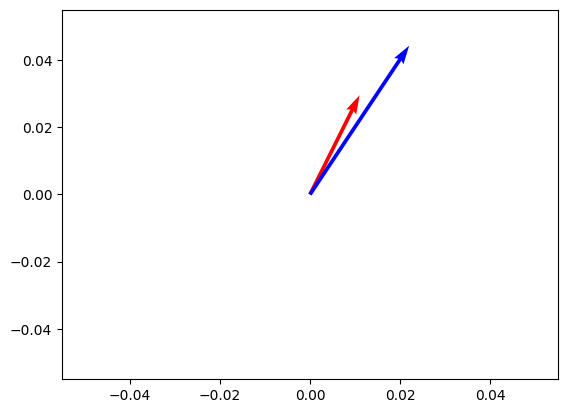

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

V = np.array([a.tolist(), b.tolist()])
origin = np.array([[0, 0], [0, 0]])  # origin point

plt.quiver(*origin, V[:, 0], V[:, 1], color=["r", "b", "g"], scale=10)
plt.show()

让我们深入了解其数学原理。余弦相似度被定义为向量的点积除以它们的大小的乘积：

$$
\text{cosine similarity}(\mathbf{A}, \mathbf{B}) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}
$$

我们已经在博客文章开头讨论了大小，我们需要计算一个向量分量的平方和的平方根。

$$
\|\mathbf{A}\| = \sqrt{1^2 + 2^2 + 3^2} = \sqrt{14}
$$

$$
\|\mathbf{B}\| = \sqrt{2^2 + 3^2 + 4^2} = \sqrt{29}
$$

我们还需要计算向量的点积，点积被定义为对应向量分量的乘积之和。

$$
\mathbf{A} \cdot \mathbf{B} = \sum_{i=1}^{n} A_i B_i
$$

在这种情况下，A和B的点积如下所示：

$$
\mathbf{A} \cdot \mathbf{B} = 1 \times 2 + 2 \times 3 + 3 \times 4 = 2 + 6 + 12 = 20
$$

最后，我们可以通过进行以下计算来计算余弦相似度:

$$
\text{cosine similarity}(\mathbf{A}, \mathbf{B}) = \frac{20}{\sqrt{14} \sqrt{29}} = 0.992583
$$

与我们上面的结果相匹配。

:::{.温馨提示}

你能想到两个余弦相似度为1的向量吗？想想方向相同但大小不同的向量。

:::

### 点积

余弦相似度不考虑大小，但在某些情况下，大小可能是有意义的。在这些情况下，**点积**是一个更好的度量标准。这意味着长度或更详细的具有相似内容的句子可能会比长度较短的具有相似内容的句子具有更高的相似度得分，这是由于它们的大小。

点积被定义为对应向量分量的乘积之和（这是我们之前做的！）

$$
\mathbf{A} \cdot \mathbf{B} = \sum_{i=1}^{n} A_i B_i
$$

如果你看一下余弦相似度公式，如果假设向量已经被归一化（即它们的大小为1），那么余弦相似度等同于点积。这意味着余弦相似度是一个归一化的点积。

让我们创建一个新的向量，[4, 6, 8]。这个向量与[2, 3, 4]的方向相同，但是长度是它的两倍。让我们计算[1, 2, 3]与[2, 3, 4]和[4, 6, 8]的点积。

In [ ]:
c = torch.FloatTensor([4, 6, 8])

print(f"Cosine Similarity between a and b: {util.cos_sim(a, b)}")
print(f"Cosine Similarity between a and c: {util.cos_sim(a, c)}")

print(f"Dot product between a and b: {torch.dot(a, b)}")
print(f"Dot product between a and c: {torch.dot(a, c)}")

Cosine Similarity between a and b: tensor([[0.9926]])
Cosine Similarity between a and c: tensor([[0.9926]])
Dot product between a and b: 20.0
Dot product between a and c: 40.0


这是有道理的！因为b和c具有相同的角度，所以a和b以及a和c之间的余弦相似度是相同的。然而，由于c比b更长，所以a和c之间的点积更高。

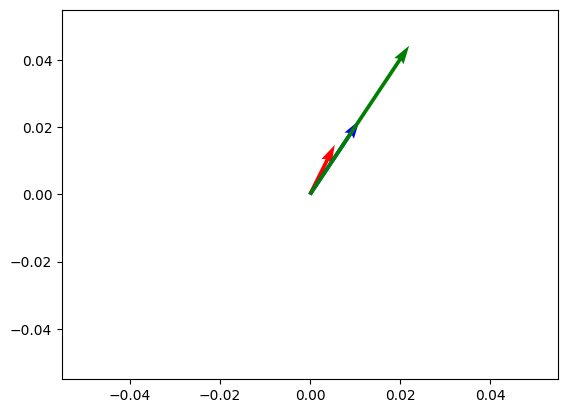

In [ ]:
V = np.array([a.tolist(), b.tolist(), c.tolist()])
origin = np.array([[0, 0, 0], [0, 0, 0]])  # origin point

plt.quiver(*origin, V[:, 0], V[:, 1], color=["r", "b", "g"], scale=20)
plt.show()

### 欧几里得距离

欧几里得距离是通过测量两个向量之间的直线距离来计算的距离。与点积一样，欧几里得距离考虑了向量的大小。我不会深入解释这两个度量标准，但主要思想是，点积度量了一个向量延伸到另一个向量方向的程度，而欧几里得距离则度量了两个向量之间的直线距离。它被定义为各个向量分量之间差的平方和的平方根。其定义为：

$$
\text{Euclidean Distance}(\mathbf{A}, \mathbf{B}) = \sqrt{\sum_{i=1}^{n} (A_i - B_i)^2}
$$

In practice, you can use the Squared Euclidean (L2-Squared)

$$
\text{Squared Euclidean}(\mathbf{A}, \mathbf{B}) = \sum_{i=1}^{n} (A_i - B_i)^2
$$

### 选择一个评分函数

我们刚刚学习了点积、余弦相似度和欧几里得距离。何时使用哪一个？

这取决于模型！某些模型将以产生归一化嵌入的方式进行训练。在这种情况下，点积、余弦相似度和欧几里得距离都会产生相同的结果。

其他模型不是以产生归一化嵌入的方式进行训练 - 它们被调整为进行点积。在这种情况下，点积将是在向量空间中找到最接近项的最佳函数。即使如此，如果大小不重要，我们仍然可以像在前面的部分中那样进行归一化。您可以根据您的用例使用不同的距离函数。具有归一化嵌入的模型将更喜欢较短的句子，而具有非归一化嵌入的模型将更喜欢较长的句子。这是因为较长句子的嵌入的大小会更大。

| Distance function | Values | When to use |
| ----------------- | ------ | ----------- |
| Cosine similarity | [-1, 1] | When the magnitude is not important |
| Dot product       | [-inf, inf] | When the magnitude is important |
| Euclidean distance | [0, inf] | When the magnitude is important |

简要总结一下：

* **余弦相似度** 关注向量之间的夹角。它是一个归一化的点积。
* **点积** 关注向量的大小和角度。
* **欧几里得距离** 用于测量向量之间的空间距离。

还有其他距离函数，例如曼哈顿距离，但这些是常见的并且对我们的用例很有用！

## 扩展

到目前为止，我们只处理了几个句子。在实践中，您可能需要处理数百万个嵌入，而我们并不总是能够计算到所有嵌入的距离（这称为蛮力搜索）。

一种方法是使用近似最近邻算法。这些算法将数据划分为相似嵌入的桶。这使我们能够快速找到最接近的嵌入，而不必计算到所有嵌入的距离。这并不是精确的，因为一些相似度很高的向量可能仍然被错过。您可以使用不同的库来实现这一点，比如Spotify的[Annoy](https://github.com/spotify/annoy)和Facebook的[Faiss](https://github.com/facebookresearch/faiss)。像Pinecone和Weaviate这样的向量数据库也使用最近邻技术，以便在毫秒内搜索数百万个对象。

现在，让我们来看一个有趣的应用，其中扩展性问题变得更加明显。

### 应用二：释义挖掘

到目前为止，通过语义搜索，我们一直在寻找与查询句子最相似的句子。在**释义挖掘**中，目标是在一个非常大的语料库中找到意思相似的文本。让我们拿我们的Quora数据集来看看是否能找到相似的问题。

In [ ]:
questions_to_embed = 10
short_corpus_questions = corpus_questions[:questions_to_embed]
short_corpus_questions

['',
 'What are the Nostradamus Predictions for the 2017?',
 'Is it expensive to take music lessons?',
 'what are the differences between first world and third world countries? Are there any second world countries?',
 'How much is a 1963 2 dollar bill with a red seal worth?',
 'What is the capital of Finland?',
 'Which is the best project management app for accounting companies?',
 "What is Dire Straits' best album ever?",
 'How does Weapon Silencers work?',
 'How should we study in medical school?']

In [ ]:
model = SentenceTransformer("quora-distilbert-multilingual")
embeddings = model.encode(short_corpus_questions, convert_to_tensor=True)

# Compute distance btween all embeddings
start_time = time.time()
distances = util.pytorch_cos_sim(embeddings, embeddings)
end_time = time.time()

print("Results (after {:.3f} seconds):".format(end_time - start_time))
distances

Results (after 0.000 seconds):


tensor([[1.0000, 0.7863, 0.6348, 0.7524, 0.7128, 0.7620, 0.6928, 0.7316, 0.6973,
         0.6602],
        [0.7863, 1.0000, 0.7001, 0.8369, 0.8229, 0.8093, 0.7694, 0.8111, 0.7849,
         0.7157],
        [0.6348, 0.7001, 1.0000, 0.6682, 0.7346, 0.7228, 0.7257, 0.7434, 0.7529,
         0.7616],
        [0.7524, 0.8369, 0.6682, 1.0000, 0.7484, 0.8042, 0.6713, 0.7560, 0.7336,
         0.6901],
        [0.7128, 0.8229, 0.7346, 0.7484, 1.0000, 0.7222, 0.7419, 0.7603, 0.8080,
         0.7145],
        [0.7620, 0.8093, 0.7228, 0.8042, 0.7222, 1.0000, 0.7327, 0.7542, 0.7349,
         0.6992],
        [0.6928, 0.7694, 0.7257, 0.6713, 0.7419, 0.7327, 1.0000, 0.7820, 0.7270,
         0.7513],
        [0.7316, 0.8111, 0.7434, 0.7560, 0.7603, 0.7542, 0.7820, 1.0000, 0.7432,
         0.7151],
        [0.6973, 0.7849, 0.7529, 0.7336, 0.8080, 0.7349, 0.7270, 0.7432, 1.0000,
         0.7243],
        [0.6602, 0.7157, 0.7616, 0.6901, 0.7145, 0.6992, 0.7513, 0.7151, 0.7243,
         1.0000]], device='c

太棒了！我们刚刚计算了10个嵌入与10个嵌入之间的距离。速度非常快。现在让我们尝试使用1000个查询。

In [ ]:
def compute_embeddings_slow(questions, n=10):
    embeddings = model.encode(
        questions[:n], show_progress_bar=True, convert_to_tensor=True
    )

    # Compute distance btween all embeddings
    start_time = time.time()
    distances = util.pytorch_cos_sim(embeddings, embeddings)
    end_time = time.time()

    return distances, end_time - start_time


_, s = compute_embeddings_slow(corpus_questions, 20000)
print("Results (after {:.3f} seconds):".format(s))

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Results (after 0.000 seconds):


好的，这仍然很快！让我们看看一些其他的值。

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/626 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Text(0, 0.5, 'Time (seconds)')

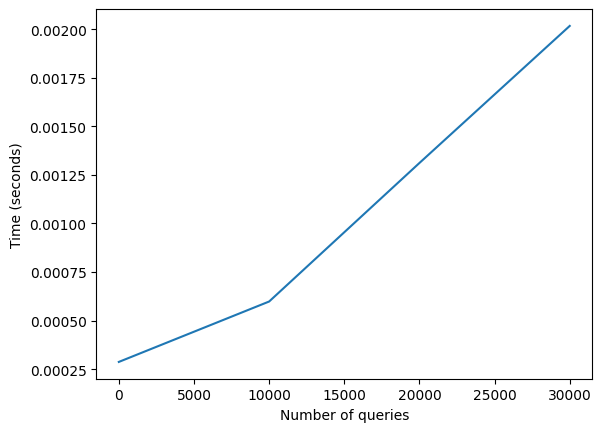

In [ ]:
import matplotlib.pyplot as plt

n_queries = [1, 10001, 20001, 30001]  # If I keep going my computer explodes
times = []

for n in n_queries:
    _, s = compute_embeddings_slow(corpus_questions, n)
    times.append(s)
    torch.cuda.empty_cache()  # Clear GPU cache

plt.plot(n_queries, times)
plt.xlabel("Number of queries")
plt.ylabel("Time (seconds)")

上述算法具有二次运行时间，因此如果我们不断增加查询数量，它将无法很好地扩展。对于更大的集合，我们可以使用[释义挖掘技术](https://www.sbert.net/examples/applications/paraphrase-mining/README.html)，这种方法更复杂、更高效。

In [ ]:
start_time = time.time()
paraphrases = util.paraphrase_mining(
    model, corpus_questions[:100000], show_progress_bar=True
)
end_time = time.time()

Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

In [ ]:
len(paraphrases)

250976

In [ ]:
paraphrases[:3]

[[0.999999463558197, 18862, 24292],
 [0.9999779462814331, 10915, 61354],
 [0.9999630451202393, 60527, 86890]]

第一个值是分数，第二个是语料库问题的索引，第三个是另一个语料库问题的索引。分数表示两个问题有多相似。

非常好！我们只需要
1. 计算了10万个问题的嵌入。
2. 获取了最相似的句子，并
3. 对它们进行了排序。

所有这些在20秒内完成！让我们看看具有最高相似度的5个匹配项。

In [ ]:
for score, i, j in paraphrases[:5]:
    print("{:.3f}\t{} and {}".format(score, corpus_questions[i], corpus_questions[j]))

1.000	How do I  increase traffic on my site? and How do I increase traffic on my site?
1.000	who is the best rapper of all time? and Who is the best rapper of all time?
1.000	How can I become an automobile engineer? and How can I become a automobile engineer?
1.000	I made a plasma vortex at my home, but why doesn't it produce a zapping sound like at time when we see sparks and does the air nearby it ionizes? and I made a plasma vortex at my home, but why doesn't it produce a zapping sound like at time when we see sparks and does the air nearby it, ionizes?
1.000	Why was Cyrus Mistry removed as the chairman of Tata Sons? and Why was Cyrus Mistry removed as the Chairman of Tata Sons?


这种方法是如何工作的？语料库被划分为较小的块，这使我们能够管理内存和计算资源的使用。块划分有两种方式：

* **查询块大小：** 决定了考虑作为潜在释义的句子的数量。这是与查询句子进行比较的句子数量，并由 `query_chunk_size` 控制（默认为5000）。
* **语料库块大小：** 决定了同时进行比较的语料库块的数量。这由 `corpus_chunk_size` 控制（默认为100000）。

例如，默认参数下，该算法每次处理5000个句子，将这些句子与语料库中剩余部分的10万个句子的块进行比较。该算法专注于获取**前几个匹配项** - 使用 `top_k`，对于查询块中的每个句子，算法只选择语料库块中的前 k 个匹配项。这意味着该算法不会找到所有的匹配项，但它会找到前几个匹配项。这是一个很好的折衷，因为我们通常不需要所有的匹配项，只需要前几个匹配项。

这两个参数使得过程更有效，因为处理数据的较小子集在计算上更容易。它还有助于节省内存，因为我们不必将整个语料库加载到内存中来计算相似度。找到这些参数的合适值是速度和准确度之间的折衷。值越大，结果越准确，但算法越慢。

:::{.温馨提示}

您可以使用 `max_pairs` 来限制返回的配对数。

:::

这是算法的伪代码：

```python
# Initialize an empty list to store the results
results = []

for query_chunk in query_chunks:
    for corpus_chunk in corpus_chunks:
        # Compute the similarity between the query chunk and the corpus chunk
        similarity = compute_similarity(query_chunk, corpus_chunk)
        # Get the top k matches in the other chunk
        top_k_matches = similarity.top_k(top_k)
        # Add the top k matches to the results
        results.add(top_k_matches)
```

## 选择和评估模型

你应该对句子嵌入有很好的理解，以及我们可以用它们做些什么。今天，我们使用了两个不同的模型，`all-MiniLM-L6-v2` 和 `quora-distilbert-multilingual`。我们如何知道该使用哪个模型？我们如何知道一个模型是否好用？

第一步是知道在哪里发现句子嵌入模型。如果您正在使用开源模型，Hugging Face Hub 允许您[按条件筛选](https://huggingface.co/models?library=sentence-transformers)。社区已经分享了超过 4000 个模型！尽管查看 Hugging Face 上的热门模型是一个很好的指标（例如，我可以看到微软的 Multilingual 5 Large 模型，一个不错的模型），但我们需要更多信息来选择一个模型。

[MTEB](https://huggingface.co/spaces/mteb/leaderboard) 让我们不用担心。该排行榜包含多个用于各种任务的评估数据集。让我们快速看一下在选择模型时我们感兴趣的一些标准。

* **序列长度** 如前所述，根据预期的用户输入，您可能需要对更长的序列进行编码。例如，如果您要对长文档进行编码，您可能需要使用具有更大序列长度的模型。另一种选择是将文档拆分为多个句子，并分别对每个句子进行编码。
* **语言** 排行榜主要包含英语或多语言模型，但您也可以找到其他语言的模型，比如中文、波兰语、丹麦语、瑞典语、德语等。
* **嵌入维度** 如前所述，嵌入维度越大，嵌入可以捕获的信息就越多。但是，计算和存储更大的嵌入会更昂贵。
* **跨任务的平均指标** 排行榜包含多个任务，例如聚类、重新排序和检索。您可以查看所有任务的平均表现，以了解模型的好坏程度。
* **特定任务的指标** 您还可以查看模型在特定任务中的表现。例如，如果您对聚类感兴趣，可以查看模型在聚类任务中的表现。

了解模型的目的也是至关重要的。一些模型将是通用模型，而另一些模型，如[Specter 2](https://huggingface.co/allenai/specter2)，则专注于特定任务，比如科学论文。我不会深入讨论排行榜中的所有任务，但你可以查看[MTEB论文](https://arxiv.org/abs/2210.07316)以获取更多信息。让我简要总结一下MTEB。

[MTEB论文中的任务图片](https://github.com/osanseviero/hackerllama/blob/main/nbs/blog/posts/sentence_embeddings/mteb.png?raw=1)

MTEB 提供了跨八项任务的 56 个数据集的基准测试，并包含 112 种语言。它很容易扩展，以将您的数据集和模型添加到排行榜中。总体而言，它是一个简单易用的工具，可帮助您找到适合您用例的速度与准确度之间的平衡点。

今天（2024年1月7日）排名第一的模型是一个大型模型，E5-Mistral-7B-instruct，大小为14.22GB，在56个数据集上的平均分数为66.63。下一个最好的开源模型之一是BGE-Large-en-v1.5，大小只有1.34GB，平均得分为64.23。而BGE的基础模型，甚至更小（0.44GB），质量为63.55！相比之下，text-embedding-ada-002，尽管提供了更大的1536维度嵌入，但质量只有60.99。在MTEB基准测试中排名第23！Cohere提供了质量更好的嵌入，质量为64.47，维度为1024。

我建议查看这个2022年的 Twitter 推文，在这个推文中，OpenAI 的嵌入被与其他嵌入进行了比较。结果非常有趣！成本要高出许多个数量级，而质量比较小的模型要低得多。

**在这一切中，不要过于专注于一个单一的数字。您应该始终关注您任务的具体指标，以及特定的资源和速度要求**

浏览 MTEB 中涵盖的不同任务是很有意思的，可以使你更好地理解句子嵌入的潜在应用

* **双语文本挖掘** 这个任务涉及在两组句子中找到最相似的句子，每组句子都是不同语言的。这对机器翻译和跨语言搜索非常重要。
* **分类** 在这个应用中，使用句子嵌入训练 logistic 回归分类器进行文本分类任务。
* **聚类** 这里，使用句子嵌入训练 k-means 模型，将相似的句子聚合在一起，有助于无监督学习任务。
* **句对分类** 这个任务涉及预测一对句子是否相似，比如确定它们是否是重复的或是释义的，有助于释义检测。
* **重新排序** 在这种情况下，基于它们与查询句子的相似性重新排列一系列参考文本，改进搜索和推荐系统。
* **检索** 这个应用涉及将查询和相关文档嵌入以找到与给定查询最相似的文档，对搜索相关任务至关重要。
* **语义相似度** 这个任务侧重于确定一对句子之间的相似性，输出连续的相似度分数，对于释义检测等任务非常有用。
* **摘要生成** 这涉及通过计算摘要与参考（人工编写的）摘要之间的相似性来对一组摘要进行评分，这在摘要生成评估中非常重要。

## 展示应用程序：在浏览器中运行嵌入模型
我们不会进行这个实操，但我想向你展示一种关于嵌入的很酷的应用。Lee Butterman 构建了一个[很酷的应用](https://leebutterman.com/wikipedia-search-by-vibes/)，用户可以使用嵌入在数百万条维基百科文章中进行搜索。**这里特别棒的是，这是离线的：嵌入存储在浏览器中，模型也直接在您的浏览器中运行 - 没有任何数据被发送到服务器！** 🤯

数据准备

* 我们首先预先计算了一个嵌入数据库。作者使用了一个小型但有效的模型，即 all-minilm-l6-v2。
* 6百万个页面 * 384维度 * 每个浮点数占用4字节 = 9.2 GB。这对用户来说下载量相当大。
* 作者使用了一种称为[矢量量化](https://en.wikipedia.org/wiki/Vector_quantization)的技术来减小数据库的大小。
* 然后将数据导出到一种名为 Arrow 的格式中，这个格式非常紧凑！

:::{.温馨提示}

不要过于担心这里的具体细节。我们的主要目标是理解这个项目的高层次概念，而不是去实践它；所以如果这是你第一次听到“量化”这个词，也请不要害怕！

:::

推理阶段

* Lee使用了transformers.js，这是一个允许在浏览器中使用JavaScript运行transformers模型的库。这需要具有量化模型。以下是一个示例：

```js
const extractor = await pipeline('feature-extraction', 'Xenova/all-MiniLM-L6-v2');
const output = await extractor('This is a simple test.', { pooling: 'mean', normalize: true });
// Tensor {
//   type: 'float32',
//   data: Float32Array [0.09094982594251633, -0.014774246141314507, ...],
//   dims: [1, 384]
// }
```

* `transformers.js` 将所有-MiniLM-L6-v2模型下载到浏览器，并用于在浏览器中计算向量值
* 然后使用 [pq.js](https://github.com/lsb/pq.js) 计算距离

您可以在 [lee的博客文章](https://www.leebutterman.com/2023/06/01/offline-realtime-embedding-search.html) 中详细了解这个项目。这是嵌入（embeddings）如何在浏览器中使用的一个很好的例子！

## 生态系统

嵌入（embeddings）周围的生态系统非常庞大。"

### 基于向量的构建方法：

* 有一些很酷的工具，比如`top2vec`和`bertopic`，专门用于构建主题嵌入。
* `keybert`是一个允许使用BERT嵌入从文档中提取关键词和关键短语的库。
* `setfit`是一个库，允许对Sentence Transformers进行有效的少样本微调，以便将其用于文本分类。

### 向量数据库

2023年是嵌入式数据库元年。[LangChain 集成部分](https://integrations.langchain.com/vectorstores)显示有65个向量存储库。从Weaviate、Pinecone和Chroma到Redis、ElasticSearch和Postgres等各种工具都有涵盖。嵌入式数据库专注于加速对向量相似性搜索，通常使用近似搜索算法。嵌入式数据库初创公司的新浪潮导致了大量资金的投入。与此同时，一些传统的数据库公司也将向量索引集成到了它们的产品中，例如Cassandra和MongoDB。

### 研究

嵌入领域的研究也非常活跃。如果你关注MTEB基准测试，它每几周就会发生变化。在这方面的一些参与者包括微软（E5模型）、Cohere、智源研究院（BGE）、阿里巴巴（GTE）、香港大学自然语言处理组（Instructor）以及Jina等众多机构。

## 结论

这是一段奇妙的旅程！我们从零开始，深入了解了句子嵌入。我们学到了它们是什么，如何计算它们，如何比较它们，以及如何扩展它们。我们还看到了一些嵌入的酷炫应用，如语义搜索和释义挖掘。希望这篇博客文章让你对句子嵌入有了深刻的理解，知道如何使用它们。这是系列文章的第一部分。还有什么可以学习的呢？

* 向量数据库的作用
* 如何在更复杂的排名系统中使用嵌入
* 主题建模
* 多模态
* 如何训练自己的向量模型
* 关于RAGs的一切

有时候需要给每个人留出一些时间！就目前而言，我建议你休息一下，检查一下你的知识。不要犹豫，修改代码并进行调试！如果你喜欢这篇博客文章，请[点亮 GitHub Star](https://github.com/osanseviero/hackerllama) 或分享它！

## 知识检查

1. 为什么 Transformer 模型比 GloVe 或 Word2Vec 在计算向量值方面更为有效？
2. BERT 中 [CLS] 标记的作用是什么，它如何帮助计算句子向量值？
3. pooler_output 和 ['CLS'] 标记向量之间有什么区别？
4. ['CLS'] 池化、最大池化和平均池化之间有什么区别
5. Transformer 模型的序列长度限制是多少，我们如何解决这个问题？
6. 何时需要对嵌入进行归一化？
7. 哪两个向量值的余弦相似度为 -1？为 0 呢？
8. 解释 paraphrase_mining 函数的不同参数。
9. 在什么情况下你会选择最适合你使用案例的模型？

## 资源

这里有许多可用的资源：

* [Sentence Transformers](https://www.sbert.net/)
* [Hugging Face Hub](https://huggingface.co/models?library=sentence-transformers)
* [MTEB Leaderboard](https://huggingface.co/blog/mteb)
